In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()
# ['GEV', 'SOLV', 'VLTO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")

stocks_to_remove = ['GEV', 'SOLV', 'VLTO', 'SW', 'AMTM']

symbols_list = [stock for stock in symbols_list if stock not in stocks_to_remove]

end_date = '2024-04-20'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

# df

[*********************100%***********************]  498 of 498 completed


### Calculate features and technical indicators for each stock.

* Garman-Klass Volatility - Garman Klass is a volatility estimator that incorporates open, low, high, and close prices of a security.
* RSI - Relative Strength Index - momentum indicator - traditionally an RSI of 70 or more is overbought, and 30 and under is oversold condition
* Bollinger Bands
* ATR
* MACD - This indicator calculates momentum differently from the RSI by comparing the relative positions of a short- and long-term moving average.
* Dollar Volume

The MACD and RSI are both contrarians by design. They go against popular opinion by signaling to buy when there is a lot of selling and signaling to sell when there is significant buying. When both indicate buying, then the security is more likely to be genuinely oversold. 

In [3]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

# df

In [4]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('D').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('D').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-05-27 A           78.224850   42.917019         -0.001314  76.742146   
           AAPL      3345.700542   23.015892         -0.002220  56.768916   
           ABBV       251.993461   43.688187         -0.047077  57.244391   
           ABT        414.390636   33.582722         -0.008683  43.277841   
           ACGL        10.809568   24.053333          0.000060  58.446568   
...                          ...         ...               ...        ...   
2024-04-19 XYL        285.289614  127.168411          0.000085  54.335018   
           YUM        229.528612  137.138443         -0.000030  55.325481   
           ZBH        155.105344  119.165138          0.000032  37.293257   
           ZBRA        94.226608  268.070007          0.000320  40.900517   
           ZTS        898.578481  145.806854          0.000179  27.952237   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-05-27 A       3.648133  3.724602  3.801071 -1.298770  0.658963  
           AAPL    3.065557  3.122285  3.179013 -1.156626 -0.114791  
           ABBV    3.741215  3.782132  3.823048 -1.053871 -0.354375  
           ABT     3.487217  3.513714  3.540210 -1.209074 -0.692962  
           ACGL    3.194482  3.209611  3.224741 -1.078173 -0.150877  
...                     ...       ...       ...       ...       ...  
2024-04-19 XYL     4.843509  4.855695  4.867881  0.292808 -0.023514  
           YUM     4.898001  4.921133  4.944265  0.054054  0.050224  
           ZBH     4.788370  4.846247  4.904123 -0.392643 -0.695631  
           ZBRA    5.607759  5.677147  5.746536  0.099219 -0.400942  
           ZTS     4.990747  5.082230  5.173712  1.210395 -3.247561  

[973290 rows x 9 columns]

In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

# get to 150
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

* Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [6]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-06-15 A           76.380877   42.092770         -0.001795  58.413083   
           AAPL      2787.583975   22.279659         -0.003253  45.815636   
           ABBV       448.004033   42.078869         -0.049742  44.675382   
           ABT        353.497736   31.984756         -0.010532  30.741974   
           ACGL        20.567038   22.940001          0.000047  34.094556   
...                          ...         ...               ...        ...   
2024-04-19 XYL        145.677842  127.168411          0.000085  54.335018   
           YUM        274.954645  137.138443         -0.000030  55.325481   
           ZBH        176.398425  119.165138          0.000032  37.293257   
           ZBRA       101.647500  268.070007          0.000320  40.900517   
           ZTS        578.849553  145.806854          0.000179  27.952237   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-06-15 A       3.748951  3.772760  3.796568 -1.422820  0.234208   
           AAPL    3.121255  3.155708  3.190161 -1.184802 -0.180939   
           ABBV    3.727771  3.780899  3.834027 -0.906771 -0.397479   
           ABT     3.483357  3.523041  3.562725 -1.382722 -0.523422   
           ACGL    3.185953  3.211922  3.237890 -1.188224 -0.394904   
...                     ...       ...       ...       ...       ...   
2024-04-19 XYL     4.843509  4.855695  4.867881  0.292808 -0.023514   
           YUM     4.898001  4.921133  4.944265  0.054054  0.050224   
           ZBH     4.788370  4.846247  4.904123 -0.392643 -0.695631   
           ZBRA    5.607759  5.677147  5.746536  0.099219 -0.400942   
           ZTS     4.990747  5.082230  5.173712  1.210395 -3.247561   

                   dollar_vol_rank  return_1m  return_2m  return_3m  \
date       ticker                                                     
2016-06-15 A                 319.0   0.000668   0.000223  -0.003096   
           AAPL                1.0  -0.003283  -0.001028  -0.005733   
           ABBV               33.0   0.008347   0.003913  -0.003290   
           ABT                55.0  -0.006107  -0.005695  -0.008492   
           ACGL              451.0  -0.011633  -0.010230  -0.012654   
...                            ...        ...        ...        ...   
2024-04-19 XYL               382.0   0.005348   0.006397  -0.000417   
           YUM               229.0   0.004570   0.002428   0.001206   
           ZBH               332.0   0.000838  -0.007738  -0.007262   
           ZBRA              450.0  -0.018166  -0.014721  -0.014901   
           ZTS               100.0  -0.043172  -0.016666  -0.013474   

                   return_6m  return_9m  return_12m  
date       ticker                                    
2016-06-15 A       -0.002973  -0.002346   -0.001615  
           AAPL    -0.003206  -0.000661   -0.002706  
           ABBV    -0.007262  -0.008275   -0.003123  
           ABT     -0.006527  -0.006047   -0.004054  
           ACGL    -0.006416  -0.006030   -0.003941  
...                      ...        ...         ...  
2024-04-19 XYL     -0.001233   0.000078   -0.000662  
           YUM      0.000205   0.002667   -0.000306  
           ZBH     -0.010864  -0.006536   -0.007048  
           ZBRA    -0.017233  -0.011274   -0.007312  
           ZTS     -0.016892  -0.013272   -0.008604  

[967314 rows x 16 columns]

* Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [20]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-06-30 A      -0.0005  0.0045 -0.0148  0.0141  0.0194   0.016382
           AAPL   -0.0005  0.0045 -0.0148  0.0141  0.0194   0.012712
           ABBV   -0.0005  0.0045 -0.0148  0.0141  0.0194   0.001618
           ABT    -0.0005  0.0045 -0.0148  0.0141  0.0194   0.019186
           ACGL   -0.0005  0.0045 -0.0148  0.0141  0.0194   0.030043
...                   ...     ...     ...     ...     ...        ...
2024-02-29 XYL     0.0507 -0.0076 -0.0352 -0.0198 -0.0216   0.011303
           YUM     0.0507 -0.0076 -0.0352 -0.0198 -0.0216  -0.001299
           ZBH     0.0507 -0.0076 -0.0352 -0.0198 -0.0216   0.001853
           ZBRA    0.0507 -0.0076 -0.0352 -0.0198 -0.0216   0.024487
           ZTS     0.0507 -0.0076 -0.0352 -0.0198 -0.0216  -0.008052

[32767 rows x 6 columns]

In [21]:
# * Filter out stocks with less than 10 months of data.
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-06-30 A      -0.0005  0.0045 -0.0148  0.0141  0.0194   0.016382
           AAPL   -0.0005  0.0045 -0.0148  0.0141  0.0194   0.012712
           ABBV   -0.0005  0.0045 -0.0148  0.0141  0.0194   0.001618
           ABT    -0.0005  0.0045 -0.0148  0.0141  0.0194   0.019186
           ACGL   -0.0005  0.0045 -0.0148  0.0141  0.0194   0.030043
...                   ...     ...     ...     ...     ...        ...
2024-02-29 XYL     0.0507 -0.0076 -0.0352 -0.0198 -0.0216   0.011303
           YUM     0.0507 -0.0076 -0.0352 -0.0198 -0.0216  -0.001299
           ZBH     0.0507 -0.0076 -0.0352 -0.0198 -0.0216   0.001853
           ZBRA    0.0507 -0.0076 -0.0352 -0.0198 -0.0216   0.024487
           ZTS     0.0507 -0.0076 -0.0352 -0.0198 -0.0216  -0.008052

[32767 rows x 6 columns]

In [23]:
# Calculate rolling factors beta
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2016-06-30 A            NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACGL         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-02-29 XYL     0.109409 -0.253075  0.246130  0.069179 -0.454882
           YUM     0.058875 -0.111485  0.167427  0.034602 -0.191196
           ZBH     0.163402 -0.335560  0.149320 -0.169072 -0.191671
           ZBRA    0.126072 -0.023943  0.222863  0.000866 -0.299859
           ZTS     0.052198 -0.106205  0.055942  0.066980 -0.064975

[32767 rows x 5 columns]

In [26]:
# * Join the rolling factors data to the main features dataframe.
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

# data.info()

ValueError: columns overlap but no suffix specified: Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

* K-Means Clustering:
  * You may want to initialize predefined centroids for each cluster based on your research.

  * For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

  * Then we will pre-define our centroids for each cluster.

In [27]:
from sklearn.cluster import KMeans

# Sometimes need to drop the cluster if recalculating
# data = data.drop('cluster', axis=1)

### Apply pre-defined centroids.
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

# data

ValueError: The shape of the initial centers (4, 18) does not match the number of features of the data 30.

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


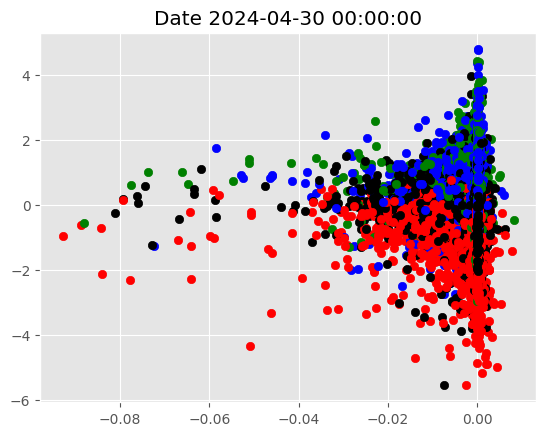

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [20]:
filtered_df = data[data['cluster']==0].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


In [22]:
# * Download Fresh Daily Prices Data only for short listed stocks.
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

# new_df

[*********************100%%**********************]  156 of 156 completed


* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [23]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

# portfolio_df

Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-08-01, Continuing with Equal-Weights

* Visualize Portfolio returns and compare to SP500 returns.

In [24]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

# portfolio_df

[*********************100%%**********************]  1 of 1 completed


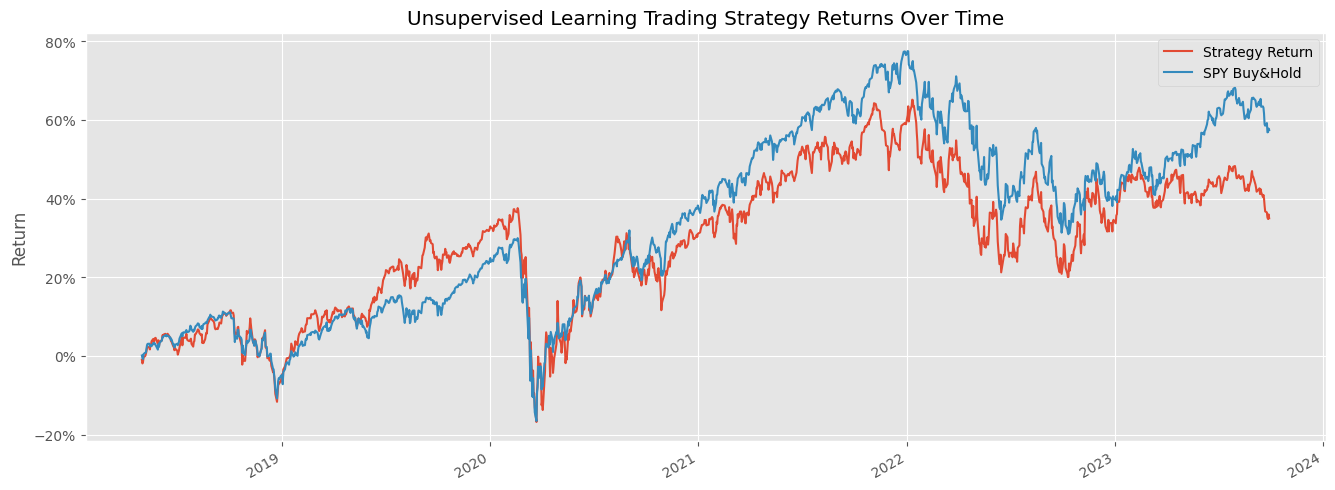

In [25]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
